- Eric Sundstrom
- Data Science Online Program
- Part-Time Cohort 3/19
- Instructor - Victor Geislinger
- Capstone

# Intro

For my Capstone Project, I decided to tackle the (already completed) Kaggle Competition: Toxic Comment Classification Challenge by Jigsaw and Conversation AI

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Going through the curriculum, NLP Natural Language Processing stood out to me.  There seemed to be so many options one could take to improve your model, from pre-processing, tokenization, to the modeling itself.  So I thought completing this task would be a great chance to dive deeper into the subject.

# About The Project

- The goal of this task was to create a model to analyze comments from past Wikipedia edit pages and classify them for 6 different types of toxicity:

- toxic
- severe toxic
- obscene
- threat
- insult
- identity hate

- This is a multi-label classification task.  Each label, itself, is a binary classification task

- These comments were gathered from Wikipedia, from the time period of 2004 to 2015.  The comments were hand-labeled by real people via crowdsourcing.

- The ultimate goal being, for Wikipedia and other places where there is online communication, finding more accurate ways to automatically remove comments that contain toxicity.  Toxicity is harmful to people and stunts productive communication.

- I think the point of not just classifying toxic vs non-toxic, but incorporating these sub groups of toxicity is because some online forums are okay with obscenities but not if used in making threats or insults, etc.

# Overview of the Data

### Preview

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


### Train Dataset Size

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


- We can see the train dataset has about 160,000 comments in it

***

### Test Dataset Size

In [4]:
holdout = pd.read_csv('test.csv')
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


- The test data set appears to have about 150,000 comments.  But it was later revealed that many of these were not actually used to evaluate competitor's models, they were just decoys.

- The decoys were obvious because their labels were all -1, instead of a valid 0 or 1 value

### Merge Test Comments & Labels

- By merging dataframes of the test comments and test labels we can easily filter out the decoys so we only use the comments actually used in evaluation

In [5]:
test_labels_df = pd.read_csv("test_labels.csv")
holdout = holdout.merge(test_labels_df, on='id')
holdout.drop(holdout[holdout['toxic']==-1].index, inplace=True)
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63978 entries, 5 to 153156
Data columns (total 8 columns):
id               63978 non-null object
comment_text     63978 non-null object
toxic            63978 non-null int64
severe_toxic     63978 non-null int64
obscene          63978 non-null int64
threat           63978 non-null int64
insult           63978 non-null int64
identity_hate    63978 non-null int64
dtypes: int64(6), object(2)
memory usage: 4.4+ MB


- So we see now that our test set really only contains 63,978 comments

# Exploration

### Distribution

Let's look at a breakdown of each label to better understand what type of comments we have been provided in our train data

- Here is a look again at our class labels

In [6]:
labels = list(train.columns[2:])
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [7]:
train[labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

- So we can see here that the generic toxic class is by far the most plentiful.  While the threat class is the least represented

***

### Distribution of Labels for each comment

- Because each comment can be marked positive for 6 different labels, another good way to look at our data is to see how many labels each comment was classified positively for in total.

- Let's create a temporary column for total labels applied

In [8]:
train['total'] = train[labels].sum(axis=1)
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


In [9]:
train['total'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: total, dtype: int64

- This makes it easy to see that 143346 (89.8% of the total) comments were not labeled for any type of toxicity, so by default they are non-toxic.

- Notably, only 6 comments were labeled positively for ALL types of toxicity

***

### Example Comments

To create a clear contrast for the type of comments in our dataset, let's observe a non-toxic comment and one of the 31 comments that was labeled for all types of toxicity

In [10]:
import random

In [11]:
random.choice(list(train.loc[train['total']==0, 'comment_text']))

'Minor Counties \n\nReference should be made to the work on the Minor Counties. A very solid piece of primary research over many years.'

In [12]:
random.choice(list(train.loc[train['total']==6, 'comment_text']))

"Go fuck yourself!!! you fucking delteted it anyway! whats the fucking point of a public Encyclopedia if you delete evrything!?!?!? I've edited a few pages so that they are more dettailed and wtf do you all do!?!!?!?!?!?! fucking get rid of it!!!!!!! and dumb down articles just to cater for you publicly ignorant american twats I hope George Bush gets killed by Islams fuck you all!!"

- This makes it easy to see why we to need control toxic communication on the internet

***

### Maximum Character Limit per Comment?

How long are these comments, usually? Is there a max limit?

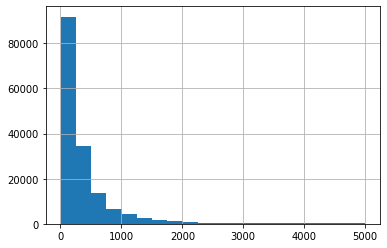

In [13]:
comment_char_length = [len(x) for x in train['comment_text']]
pd.Series(comment_char_length).hist(bins=20)

In [14]:
pd.Series(comment_char_length).describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
dtype: float64

- We can see that there is a maximum character limit for this dataset, 5000.  But the average character length is 394

# Frequency Distributions

Let's take a look at the most common words in the corpus (all comments combined together) of toxic comments vs. non-toxic comments

### Create 2 Corpus, 1 for Non-Toxic 1 for Toxic

To make this easier to process, let's combine all the toxicity classes together for a general toxic corpus, and then a non-toxic corpus

In [15]:
clean_comments_df = train[train['total']== 0]
toxic_comments_df = train[train['total'] > 0]

### Tokenize Each Corpus

- NLTK's FreqDist function expects the text to already be in tokenized form, so we will have to do that first.  As it is now, each comment is just a single string of text

In [16]:
from nltk import FreqDist
from nltk import TweetTokenizer

- I like to use NLTK's TweetTokenizer to turn these comments into word tokens.  It does not split words on their apostrophes, which I like because you don't end up with fragments of what the intended word was supposed to be (for example the word "they're" stays that way instead of being split into "they" and "re")

- It also has reduce_len parameter that replaces repeated character sequences of 3 or more with just the sequence of 3

- The preserve_case parameters will be set to False because we want the text in lower-case form

- Basically, this function is better able to handle informal text conversation like we see with our Wikipedia edit comments

In [17]:
twt_tknzr = TweetTokenizer(preserve_case=False, reduce_len=True)
clean_tokens = [twt_tknzr.tokenize(x) for x in clean_comments_df['comment_text']]
toxic_tokens = [twt_tknzr.tokenize(x) for x in toxic_comments_df['comment_text']]

### Inspect Sample of Tokens

We can see from an example of a comment now in tokenized form, stop words and punctuation are still included.  

In [18]:
clean_tokens[0]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'were',
 'reverted',
 '?',
 'they',
 "weren't",
 'vandalisms',
 ',',
 'just',
 'closure',
 'on',
 'some',
 'gas',
 'after',
 'i',
 'voted',
 'at',
 'new',
 'york',
 'dolls',
 'fac',
 '.',
 'and',
 'please',
 "don't",
 'remove',
 'the',
 'template',
 'from',
 'the',
 'talk',
 'page',
 'since',
 "i'm",
 'retired',
 'now',
 '.',
 '89.205',
 '.',
 '38.27']

- We can now remove those to more clearly see what words best characterize toxic comments and non-toxic comments

### Remove Stop Words and Punctuation

In [19]:
from nltk.corpus import stopwords
import string

In [20]:
stopwords = stopwords.words('English') + list(string.punctuation)

clean_tokens_stops_removed = []
for token_list in clean_tokens:
    new_tokens = [token for token in token_list if token not in stopwords]
    clean_tokens_stops_removed.append(new_tokens)
    
toxic_tokens_stops_removed = []
for token_list in toxic_tokens:
    new_tokens = [token for token in token_list if token not in stopwords]
    toxic_tokens_stops_removed.append(new_tokens)
    


### Re-inspect Sample Tokens

In [21]:
clean_tokens_stops_removed[0]

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'vandalisms',
 'closure',
 'gas',
 'voted',
 'new',
 'york',
 'dolls',
 'fac',
 'please',
 'remove',
 'template',
 'talk',
 'page',
 'since',
 "i'm",
 'retired',
 '89.205',
 '38.27']

- As you can see, numbers are still included in these tokens, but we will leave it as it is for now and revisit doing more pre-processing before we do our modeling

### Flatten Nested List of Tokens for FreqDist()

FreqDist wants 1 big list of tokens and not a list of each comment's list of tokens so we have to flatten the nested list before executing the function

In [22]:
all_comments_together_clean = []
for comment in clean_tokens_stops_removed:
    all_comments_together_clean += comment
    
all_comments_together_toxic = []
for comment in toxic_tokens_stops_removed:
    all_comments_together_toxic += comment

### Create Frequency Distribution for Clean Corpus & Inspect 20 Most Common Words

In [23]:
frq_dist_clean = FreqDist(all_comments_together_clean)
frq_dist_clean.most_common(20)

[('article', 54154),
 ('page', 43505),
 ('wikipedia', 39511),
 ('talk', 35219),
 ('please', 28654),
 ('would', 28085),
 ('one', 26513),
 ('like', 23987),
 ('see', 20525),
 ('also', 19774),
 ('think', 18670),
 ('edit', 16718),
 ('know', 16688),
 ('...', 16556),
 ("i'm", 16232),
 ('articles', 15994),
 ('use', 15859),
 ('people', 15809),
 ('may', 15245),
 ('time', 14330)]

### Create Frequency Distribution for Toxic Corpus & Inspect 20 Most Common Words

In [24]:
frq_dist_toxic = FreqDist(all_comments_together_toxic)
frq_dist_toxic.most_common(20)

[('fuck', 9623),
 ('like', 3781),
 ('shit', 3660),
 ('wikipedia', 3553),
 ('nigger', 3294),
 ('suck', 3245),
 ('fucking', 3238),
 ('go', 2963),
 ('ass', 2954),
 ('...', 2904),
 ('u', 2903),
 ('hate', 2637),
 ('get', 2440),
 ('page', 2356),
 ('know', 2354),
 ('gay', 2255),
 ('die', 2141),
 ('faggot', 2026),
 ('people', 1994),
 ('fat', 1981)]

- 0 of the top 20 words in non-toxic comments are vulgar or meant to be derogatory vs. 11 of the top 20 words in toxic comments

- The difference between the words used in each of these corpus' is stark, as you would probably expect.

# TF-IDF

- A more sophisticated way to characterize the most important words in a corpus, as opposed to another, is using TF-IDF (Term Frequency- Inverse Document Frequency).  

- This method highlights words that are exclusive to a corpus, rather than being common in both. 

### Join List of Tokens to One Big String for each Corpus

- Unlike FreqDist, TfidfVectorizer takes in a string rather than a list of tokens so we'll need to join all our tokens together as one big string

In [25]:
clean_string_tfidf = ' '.join(all_comments_together_clean)
toxic_string_tfidf = ' '.join(all_comments_together_toxic)
corpi = [clean_string_tfidf, toxic_string_tfidf]

### Transform Corpi into Vectors using TfidfVectorizer()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
vectorizer = TfidfVectorizer()
corpi_tfidf = vectorizer.fit_transform(corpi)

- Now, each text corpus has been transformed into a vector of TF_IDF scores.  
- Basically, the higher the score, the more important it is deemed to be in describing the nature of the document.  

### Inspect Top 20 TFIDF Scores from Clean Corpus

In [28]:
clean_corpus = corpi_tfidf[0]
df = pd.DataFrame(clean_corpus.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
article,0.348036
wikipedia,0.276245
page,0.273354
talk,0.221235
please,0.178194
would,0.174744
one,0.170518
like,0.150177
see,0.127589
also,0.122916


### Inspect Top 20 TFIDF Scores from Toxic Corpus

In [29]:
toxic_corpus = corpi_tfidf[1]
df = pd.DataFrame(toxic_corpus.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
fuck,0.508336
wikipedia,0.199827
like,0.193523
shit,0.187830
fucking,0.169632
nigger,0.168056
suck,0.165158
ass,0.152653
go,0.150671
hate,0.135014


- Surprisingly, words like Wikipedia and "page" have high scores for both corpi.  

- But overall the results are very similar to the most common words in the Frequency Distributions

***

### Create Bigrams instead of Unigrams for our Tfidf Vectors & Inspect top 20 for Each Corpus

- This will give us an idea of the most common pairs of words rather than just any word by itself.  This can give more insight into the meaning of the text

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(2,2))
corpi_tfidf = vectorizer.fit_transform(corpi)

In [31]:
clean_corpus = corpi_tfidf[0]
df = pd.DataFrame(clean_corpus.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
talk page,0.522786
speedy deletion,0.180529
would like,0.144818
fair use,0.129308
http www,0.127827
feel free,0.094996
blocked editing,0.094831
talk contribs,0.090923
talk pages,0.086233
please stop,0.085862


- This highlights the importance of pre-processing of text data for NLP projects.  http & www, wikipedia & org, en & wikipedia are all just parts of URLs that were split on the period (.) during tokenization.  Many would argue that URLs are not helpful in identifying document purpose

In [32]:
toxic_corpus = corpi_tfidf[1]
df = pd.DataFrame(toxic_corpus.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
fuck fuck,0.319054
moron hi,0.218683
hi moron,0.218238
nigger nigger,0.212558
jew fat,0.182952
fat jew,0.181766
shit shit,0.170498
suck suck,0.168571
ass ass,0.167088
hate hate,0.165616


### Do our Comments contain lots of spamming?

- The fact that almost all of these bigrams are the same word twice leads me to believe these existed in comments where someone just spammed the same foul words over and over again, with no real meaning.  Because even if someone was cussing at somebody, rarely does a direct attack include the same word repeated back-to-back

- So I think it's possible these bigram results are not representative of the comments as a whole, but skewed by a few long spam messages of cuss words repeated over and over again.

### Inspect 20 Longest Comments in Dataset for Spamming

Here is a quick look to see if this theory may be true

In [33]:
train['char_total'] = [len(x) for x in train['comment_text']]
train.sort_values(by=['char_total'], ascending=False).head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total,char_total
46583,7c7a4bf4c84fe002,hahahahahahahahahahahahahahahahahaha vandalism...,1,0,0,0,0,0,1,5000
47715,7f79fd5eacbe804c,Block Block Block Block Block Block Block Bloc...,0,0,0,0,0,0,0,5000
74753,c7f72686bf613e4e,Dont Change It!!!! zzzzzzzzzzzzzzzzzzzzzzzzzzz...,0,0,0,0,0,0,0,5000
42061,70368dd072aebb42,WANKER WANKER WANKER WANKER WANKER WANKER WANK...,1,0,0,0,0,0,1,5000
72192,c14532e93d456260,China smells like fart. China smells like fart...,1,0,0,0,0,0,1,5000
75165,c91d629c6599bb23,IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN T...,0,0,0,0,0,0,0,5000
56834,97e695cfd71944ed,i CAN STILL POST WITH THIS COMPUTER...I SAID B...,1,1,1,0,1,0,4,5000
46197,7b6b88051eb69303,heil hitler! heil hitler! heil hitler! heil hi...,1,0,0,0,0,0,1,5000
131729,c0e076f0011acaa6,"""FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...",1,1,1,0,1,0,4,5000
128782,b0b8f1eaa83616fe,sex fucksex fucksex fucksex fucksex fucksex fu...,1,1,1,0,0,0,3,5000


- Wow, it is amazing to see, just from the looking at the top 20 comments in total length, how many of the comments are clearly just spamming words

# Preparation for Modeling

- Lots of steps have to be taken so that a machine learning model can process these comments for analysis. There are all sorts of different ways this can done so this is just the direction I went:

- Pre-processing
- Tokenization
- Stemming

- Preprocessing is always important to try in NLP, both for possible improvement to the eventual model and for reducing the size of the data/increasing runtimes for subsequent operations



## Pre-processing

- Unfortunately, many things other than the words people use to actually communicate with each other, can be found in our text data.  

- These things include:
    - new-line symbols 
    - IP addresses
    - usernames
    - website addresses 
    - auto-generated strings.  
    
- These types of things don't contain information on toxicity.  We know from common sense, that is not how toxicity or non-toxicity is communicated by humans, even in text form.

- Even though something like IP addresses and usernames, which might give clues to the users who tend to be toxic or not, might seem helpful, I think it's better to do without them because ultimately the goal is to predict on unseen data which probably will not have these same usernames and IP addresses

### Creating a function for all string manipulation

- I made this function to remove these things from a comment, all at one time (I used regular expressions (via the re library) to locate the text I wanted removed)

In [34]:
import re

In [35]:
def preprocess(comment):
    # lower everything
    comment = comment.lower()
    #get rid of new line symbols
    comment = re.sub('\\n',' ',comment)
    #remove user:: fragments
    comment = re.sub("user::\w*",' ',comment)
    #remove anything with user
    comment = re.sub("\[\[user.*",' ',comment)
    #remove IP addresses
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",' ',comment)
    #remove http links
    comment = re.sub("(http://.*?\s)|(http://.*)",' ',comment)
    #remove https links
    comment = re.sub("(https://.*?\s)|(https://.*)",' ',comment)
    #remove email addresses
    comment = re.sub("(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)",' ',comment)
    #remove wp: fragments
    comment = re.sub("wp:\w*",' ',comment)
    #remove these auto generated strings
    comment = re.sub("preceding unsigned comment added by",' ',comment)
    #remove all punctuation besides '
    string_w_o_comma = re.sub("'", '', string.punctuation)
    comment = comment.translate(str.maketrans('','', string_w_o_comma))
    return comment

### Make Copy of Comments for Comparison

- Before I make changes to our dataset, I want to create a copy of the original, so that I can show that these changes are working

In [36]:
original_df = train.copy()

### Apply Preprocess function to entire dataset

- Our preprocess() function only alters 1 comment at a time, so now we need to use the apply function in Pandas to execute this function on every comment in our Pandas Series ['comment text'], where all our comments are stored

In [37]:
train['comment_text'] = train['comment_text'].apply(preprocess)
holdout['comment_text'] = holdout['comment_text'].apply(preprocess)

### Check to see if changes are successful

- Now let's compare, to see the effect the changes had

In [38]:
# Random Number to select comment
# Has to be done before comment selection because we need to get the same comment from each dataframe 
random_number = random.randint(0,len(train))

In [39]:
print(original_df['comment_text'].loc[random_number])

"
CEDEM is the Electoral Commission...? And is ""1"" the best as in school grades, or is ""5"" the best? — "


In [40]:
print(train['comment_text'].loc[random_number])

 cedem is the electoral commission and is 1 the best as in school grades or is 5 the best — 


***

### Replace Contractions

- One other pre-processing step I would like to try is to change contractions to their expanded words

#### Create Dictionary of Contractions and Replacements

In [41]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'll": "how will", "how's": "how is",  "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "i'd": "i would", "i'll": "i will", "i'm": "i am", "isn't": "is not", "it'd": "it would", "it'll": "it will","it's": "it is", "let's": "let us", "ma'am": "madam", "might've": "might have","mightn't": "might not", "must've": "must have", "mustn't": "must not", "needn't": "need not", "shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not", "so've": "so have","that'd": "that would", "that's": "that is", "there's": "there is", "here's": "here is","they'd": "they would","they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "y'all": "you all","you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have"}

#### Use string.replace to substitute each contraction

In [42]:
for replacee, replacer in contraction_dict.items():
    train['comment_text'] = train['comment_text'].map(lambda x: x.replace(replacee, replacer))
    holdout['comment_text'] = holdout['comment_text'].map(lambda x: x.replace(replacee, replacer))

### Verify Results

- Now we will compare with the original again, to see if our code worked in replacing contractions

In [43]:
random_number = random.randint(0,len(train))

In [44]:
print(original_df['comment_text'].loc[random_number])

You're correct, I missed this: Note: There is no requirement for the reverts to be related: any four reverts on the same page count. I cannot argue with the block.


In [45]:
print(train['comment_text'].loc[random_number])

you are correct i missed this note there is no requirement for the reverts to be related any four reverts on the same page count i cannot argue with the block


***

### Remove Digits

- Since numbers are generally not used to express toxicity, they will just be taking up space.  So let's get rid of them now

In [46]:
train['comment_text'] = train['comment_text'].map(lambda x: ''.join([i for i in x if not i.isdigit()]))
holdout['comment_text'] = holdout['comment_text'].map(lambda x: ''.join([i for i in x if not i.isdigit()]))

## Tokenization

- I had to do the tokenization step on my own instead of leaving it to the SKLearn TfidfVectorizer function because I want to stem the words in our comments.  And it is easier and faster to have the text already in token form when executing the stem function

- Again, I will use TweetTokenizer() for tokenization

In [47]:
tknzr = TweetTokenizer(preserve_case=False, reduce_len=True)
tokens_train = [tknzr.tokenize(x) for x in train['comment_text']]
tokens_test = [tknzr.tokenize(x) for x in holdout['comment_text']]

## Stemming

- Stemming takes variations of the same word and makes them all the same word

- The PorterStemmer is a popular type of stemmer but there are other types.  I also tried the SnowballStemmer also from sklearn but the Porter Stemmer performed slightly better

- Before I decided to use stemming, I tried out lemmatization on this data.  But it is a more complicated process than stemming so the runtimes were too long to be acceptable. I used the NLP library called Spacy during these attempts 

In [48]:
from nltk.stem.porter import PorterStemmer

In [49]:
porter = PorterStemmer()
stemmed_tokens_train = [[porter.stem(token) for token in tokens] for tokens in tokens_train]
stemmed_tokens_test = [[porter.stem(token) for token in tokens] for tokens in tokens_test]

### Turn list of tokens back into a string, for each comment

- TfidfVectorizer will want the comments as strings and not a list of tokens so we must do an operation to make strings out of each list of tokens

In [50]:
stems_for_tfidf_train = list(map(' '.join, stemmed_tokens_train))
stems_for_tfidf_test = list(map(' '.join, stemmed_tokens_test))

## Prepare X and Y

- Let's finish our preparations for modeling before moving on, by defining our X and Y variables.  
- These will be going directly into whatever models we create

In [51]:
# First, drop added columns
train.drop("char_total", axis=1, inplace=True)
train.drop("total", axis=1, inplace=True)

In [52]:
X_train = stems_for_tfidf_train
y_train = train.iloc[:,2:]

X_test = stems_for_tfidf_test
y_test = holdout.iloc[:,2:]

## Tfidf Vectorization Best Parameters

- I have already tuned the parameters for this process (using GridSearchCV) and found that the following yielded the best results:

- sublinear_tf = True 
- max_features = 50,000
- strip_accents = 'ascii'
- analyzer = 'word'
- stop_words = None
- ngram_range = (1,1)

# Modeling

- This is a multi-label classification problem.  
- The task is to create a prediction for each label, for each comment. 
- Each label is binary rather than multi-class.  For example, the prediction to whether a comment is a threat is always 1 or 0, yes or no.

- This task calls for scoring using ROC_AUC (Receiver Operating Curve - Area Under Curve).  This is a good evaluator because it tells us how well the model can identify a positive as a positive, but also when a negative is a negative

# Logistic Regression - Baseline

- For the implementation of the baseline model, I will manually run a classifier for each label.  
- There are other ways to do this using sklearn but this way it is easy to see what is going on, and the scores for each label

### Vectorization (Prepare Data For Model)

In [53]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(strip_accents='ascii', sublinear_tf=True, max_features=50000)

# fit and transform on it the training features
word_vectorizer.fit(X_train)
X_train_word_features = word_vectorizer.transform(X_train)

#transform the test features to sparse matrix
test_features = word_vectorizer.transform(X_test)

### Run Classifiers, Output Scores

- Our evaluator, the auc roc score, deals with probabilities so we need to use the predict_proba function instead of the predict function

- This code below will output the auc_roc score for each label, and then the mean of all the scores to tell us our overall score for the model

In [54]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np

In [55]:
label_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

auc = []

for label_name in label_names:
    
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[label_name]
    test_target = y_test[label_name]
    classifier = LogisticRegression(solver='liblinear')

    
    classifier.fit(X_train_word_features, train_target)
    y_pred_prob = classifier.predict_proba(test_features)[:,1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("ROC_AUC score for the {} label is {}\n".format(label_name,auc_score))
    
print(('\033[1m' + 'Total average ROC_AUC score is {}' + '\033[0m').format(np.mean(auc)))

ROC_AUC score for the toxic label is 0.961616292227514

ROC_AUC score for the severe_toxic label is 0.9824199471609563

ROC_AUC score for the obscene label is 0.9756028080025071

ROC_AUC score for the threat label is 0.9897933731935957

ROC_AUC score for the insult label is 0.9682701933860691

ROC_AUC score for the identity_hate label is 0.9802074538501074

Total average ROC_AUC score is 0.9763183446367917


### Briefly visit Class Imbalances (in test set) before moving on

- Before we move on with modeling, I think it is good to remember how imbalanced the data for each label is, as this naturally will affect each score.  

In [56]:
for label in y_test.columns:
    imb = y_test[label].value_counts(normalize=True)
    print("the class imbalance for the {} label is:\n\n {}\n\n".format(label,list(imb)))    

the class imbalance for the toxic label is:

 [0.9048110287911469, 0.09518897120885304]


the class imbalance for the severe_toxic label is:

 [0.9942636531307637, 0.0057363468692363]


the class imbalance for the obscene label is:

 [0.9423082934758823, 0.05769170652411767]


the class imbalance for the threat label is:

 [0.9967019913095126, 0.003298008690487355]


the class imbalance for the insult label is:

 [0.9464347119322267, 0.053565288067773296]


the class imbalance for the identity_hate label is:

 [0.9888711744662227, 0.011128825533777236]




- Looking at the toxic label, we see that for the test set approx 90% of the comments are labeled toxic while the other 10% were not.  So even by random chance we would still expect a 90% success rate if we guessed every comment was non-toxic.  Therefore we will hope to see our evaluation scores higher than the class imbalance ratio

- Looking at our results of the baseline mode, the severe_toxic, threat, and identity_hate labels all performed worse than random guessing.  This is obviously something we will be looking to improve upon as we tune the parameters of our Logistic Regression model

#### Okay, now back to modeling

# Logistic Regression - w/ Parameters Tuned

- Instead of manually running a classifier on each label individually like we did for the baseline model, sklearn offers built-in classes that do multi-label classification automatically.

- I was able to find 2 options for this, OneVsRestClassifier and MultiOutputClassifier.  The OneVsRestClassifier is built to handle multi-class classification but the docs suggest that it also works for multi-label classification:

"This strategy can also be used for multilabel learning, where a classifier is used to predict multiple labels for instance, by fitting on a 2-d matrix in which cell [i, j] is 1 if sample i has label j and 0 otherwise."

- The OneVsRestClassifier seemed a little faster than the MultiOutPutClassifier so I used this method

### Best Parameters

- solver = 'sag'
- C = 2
- class_weight = None

### Create Pipeline

In [57]:
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [58]:
pipe_lr = make_pipeline(
    TfidfVectorizer(sublinear_tf=1, max_features=50000, strip_accents='ascii'),
    OneVsRestClassifier(LogisticRegression(solver='sag', C=2))
)

### Get Score (w/ Cross Validation) for Train Dataset

In [59]:
train_score = np.mean(cross_val_score(pipe_lr, X_train, y_train, cv=3, scoring='roc_auc'))
train_score

0.9815438159242728

### Get Score (w/ Cross Validation) for Test Dataset

In [60]:
pipe_lr.fit(X_train, y_train)
test_preds = pipe_lr.predict_proba(X_test)
test_score = metrics.roc_auc_score(y_test, test_preds)
test_score

0.9765287876495451

### Thoughts on Results

- I see 2 main things for these results:
    - Our score only increased by .0002 with the best performing parameters.  That is disappointing
    - There seems to be some slight overfitting, as the difference between the train score and test score is .4%

- Nevertheless, this is the best results a logistic regression model could do

# Random Forest

- The other machine learning model I would like to try is the Random Forest
- We will do it the same way we did with Logistic Regression
- Here we go

## Baseline

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
label_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

auc = []

for label_name in label_names:
    
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[label_name]
    test_target = y_test[label_name]
    classifier = RandomForestClassifier(n_estimators=10)

    
    classifier.fit(X_train_word_features, train_target)
    y_pred_prob = classifier.predict_proba(test_features)[:,1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("ROC_AUC score for the {} label is {}\n".format(label_name,auc_score))
    
print(('\033[1m' + 'Total average ROC_AUC score is {}' + '\033[0m').format(np.mean(auc)))

ROC_AUC score for the toxic label is 0.9327543346259035

ROC_AUC score for the severe_toxic label is 0.8433429482853397

ROC_AUC score for the obscene label is 0.9402384310751769

ROC_AUC score for the threat label is 0.7730231514510358

ROC_AUC score for the insult label is 0.9225250879992609

ROC_AUC score for the identity_hate label is 0.8345308661094569

Total average ROC_AUC score is 0.8744024699243623


- Wow, the baseline Random Forest model did terrible.  Let's see if parameter tuning will change that

## Random Forest w/ Parameters Tuned

The best peforming parameters using GridSearch are:

- min_samples_split = 8
- min_samples_leaf = 6
- criterion = 'entropy'
- max_depth = None
- class_weight = None

### Create Pipeline

In [63]:
pipe_rf = make_pipeline(
    TfidfVectorizer(sublinear_tf=True, max_features=50000, strip_accents='ascii'),
    OneVsRestClassifier(RandomForestClassifier(min_samples_leaf=6, min_samples_split=8, criterion='entropy'))
)

### Get Score (w/ Cross Validation) for Train Dataset

In [64]:
cv_score = np.mean(cross_val_score(pipe_rf, X_train, y_train, cv=3, scoring='roc_auc'))
cv_score

0.9738634646305023

### Get Score (w/ Cross Validation) for Test Dataset

In [65]:
pipe_rf.fit(X_train, y_train)
test_preds = pipe_rf.predict_proba(X_test)
metrics.roc_auc_score(y_test, test_preds)

0.9719592771338132

### Thoughts on Results

- Huge improvement from the baseline model

- But still not as good as our logistic regression model

# Final Model (from start to finish)
## No preprocessing

- So, while I was doing testing, making small changes in all phases of the process trying to get the best score possible, I realized that the models actually did better without all the preprocessing steps.  

- That was disappointing since a lot of work went into coming up with those steps but it is interesting and notable nonetheless.

In [66]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [67]:
test_labels_df = pd.read_csv("test_labels.csv")
holdout = holdout.merge(test_labels_df, on='id')
holdout.drop(holdout[holdout['toxic']==-1].index, inplace=True)

In [68]:
tknzr = TweetTokenizer(preserve_case=False, reduce_len=True)
tokens = [tknzr.tokenize(x) for x in train['comment_text']]
tokens_test = [tknzr.tokenize(x) for x in holdout['comment_text']]

In [69]:
porter = PorterStemmer()
list_of_stems_lists = [[porter.stem(token) for token in tokens] for tokens in tokens]
test_list_of_stems_lists = [[porter.stem(token) for token in tokens] for tokens in tokens_test]

In [70]:
stems_for_tfidf = list(map(' '.join, list_of_stems_lists))
test_stems_for_tfidf = list(map(' '.join, test_list_of_stems_lists))

In [71]:
X_train = stems_for_tfidf
y_train = train.iloc[:,2:]

X_test = test_stems_for_tfidf
y_test = holdout.iloc[:,2:]

In [72]:
pipe_lr = make_pipeline(
    TfidfVectorizer(sublinear_tf=1, max_features=45000, strip_accents='ascii'),
    OneVsRestClassifier(LogisticRegression(solver='sag', C=1.85))
)

In [73]:
cv_score = np.mean(cross_val_score(pipe_lr, X_train, y_train, cv=3, scoring='roc_auc'))
cv_score

0.9822050892061615

In [74]:
pipe_lr.fit(X_train, y_train)
test_preds = pipe_lr.predict_proba(X_test)
metrics.roc_auc_score(y_test, test_preds)

0.9780044814452508

- So we see an improvement from 97.65% to 97.80% by removing all of the preprocessing steps.  

# Wrap-Up

- Best Model
    - no preprocessing
    - TweetTokenizer(preserve_case=False, reduce_len=True)
    - TfidfVectorizer(sublinear_tf=True, max_features=50000, strip_accents='ascii')
    - LogisticRegression(solver='sag', C=2)
    
- Best Score
    - Train: .9822
    - Test: .9780
    
- Kaggle Score
    - My Private Score: .97833 (rank 2745/4550)
    - My Public Score: .97714
    - Top Private Score: .98856
    - Top Public Score: .98901

- Deep Learning Attempt (See Deep Learning Notebook)
    - Train Accuracy Score: .9829
    - Validation Accuracy Score: .9822

# Conclusion

Overall, I think this project was a success.  My best model was able to classify comments for 6 different sub-classes of toxicity at an average of 97.83% accuracy.  And this is on unseen data!  Our model can recognize what makes a comment toxic and apply that to comments with potentially totally different groups of words than our training set.  That is impressive and useful because the goal is to classify new comments being made all the time.  As long as the internet exists, there will be communication between people on the internet in text form.  

Due to our model's success in classification ability, I think our shareholders would be happy.  Our model is not perfect and there are better models out there, but our model runs fast and doesn't take up a lot of resources while still being extremely accurate.  I think the model could be used exactly as it stands now, to help clean up the comments of any website that has a forum of user to user communication.  These are the places where, unfortunately, toxic language and cruelty sometimes exist.  This model can help automatically remove those comments with great speed, so users with good intentions are not subject to unjustified hate and toxicity.  The internet would be a better and more productive place overall with the use of my model and others like it.